In [1]:
from dotenv import load_dotenv
from langchain_groq import ChatGroq
from langchain_core.tools import tool
from langchain_community.tools.tavily_search import TavilySearchResults
from typing import TypedDict, Sequence, Annotated
import operator
from langchain_core.messages import BaseMessage
from langgraph.graph import StateGraph, START,END
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver

from langchain_core.messages import HumanMessage

load_dotenv()

True

In [2]:
llm=ChatGroq(model_name="deepseek-r1-distill-llama-70b")

In [3]:
@tool
def multiply(x: int, y: int) -> int:
    """Multiplies two numbers."""
    return x * y

@tool
def search(query: str):
    """search the web for a query and return the results"""
    tavily=TavilySearchResults()
    result=tavily.invoke(query)
    return f"Result for {query} is: \n{result}"


tools = [multiply, search]
tool_node=ToolNode(tools)

llm_with_tools=llm.bind_tools(tools)
memory=MemorySaver()



In [5]:
result=llm_with_tools.invoke("what is current gdp of india?")
result

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '8qdxrpyfy', 'function': {'arguments': '{"query":"current GDP of India 2023"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 63, 'prompt_tokens': 174, 'total_tokens': 237, 'completion_time': 0.270608385, 'prompt_time': 0.011530022, 'queue_time': 0.200548114, 'total_time': 0.282138407}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--a507640b-64b6-4817-bf5e-426be17a452b-0', tool_calls=[{'name': 'search', 'args': {'query': 'current GDP of India 2023'}, 'id': '8qdxrpyfy', 'type': 'tool_call'}], usage_metadata={'input_tokens': 174, 'output_tokens': 63, 'total_tokens': 237})

In [7]:
result.tool_calls

[{'name': 'search',
  'args': {'query': 'current GDP of India 2023'},
  'id': '8qdxrpyfy',
  'type': 'tool_call'}]

In [11]:
tool_mapping={tool.name:tool for tool in tools}

class AgentState(TypedDict):
    """State for the agent."""
    messages: Annotated[Sequence[BaseMessage],operator.add]

def invoke_model(state:AgentState):
    messages=state["messages"]
    question=messages[-1]
    response=llm_with_tools.invoke(question)
    return {"messages":[response]}

def router(state:AgentState):
    tool_calls=state["messages"][-1].tool_calls
    if len(tool_calls)>0:
        return "tool" #key name
    else:
        return "end" #key name

def invoke_tool(state:AgentState):
    tool_details=state["messages"][-1].tool_calls
    
    if tool_details is None:
        return Exception("No tool calls found in the last message.")
    
    print(f"Seleted tool: {tool_details[0]['name']}")
    
    if tool_details[0]["name"]=="search":
        response=input(prompt=f"[yes/no] do you want to continue with this expensive web search")
        if response.lower()=="no":
            print("web search discarded by the user. exiting gracefully")
            raise Exception("Web search discarded by the user.")
            
    
    response=tool_mapping[tool_details[0]["name"]].invoke(tool_details[0]["args"])
    return {"messages":[response]}



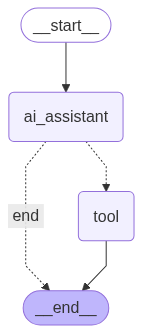

In [12]:
graph=StateGraph(AgentState)
graph.add_node("ai_assistant", invoke_model)
graph.add_node("tool", invoke_tool)
graph.add_conditional_edges("ai_assistant",
                            router,
                            {
                                "tool":"tool", ##with the key tool which value is associated <tool>
                                "end":END
                            }
                            )
graph.add_edge("tool", END)
graph.set_entry_point("ai_assistant")
app=graph.compile()
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [13]:
app.invoke({"messages":["What is the current gdp of the india?"]})

Seleted tool: search
web search discarded by the user. exiting gracefully


Exception: Web search discarded by the user.

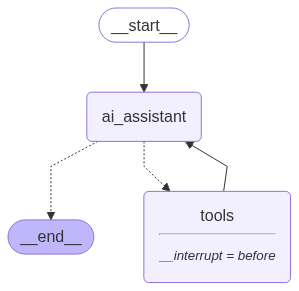

In [9]:
def ai_assistant(state:AgentState):
    response=llm_with_tools.invoke(state["messages"])
    return {"messages":[response]}

graph_builder=StateGraph(AgentState)
graph_builder.add_node("ai_assistant", ai_assistant)
graph_builder.add_node("tools", tool_node)
graph_builder.add_edge(START,"ai_assistant")
graph_builder.add_conditional_edges("ai_assistant",
                                    tools_condition,
                                    )
graph_builder.add_edge("tools", "ai_assistant")
app2=graph_builder.compile(checkpointer=memory,interrupt_before=["tools"])
from IPython.display import Image, display
display(Image(app2.get_graph().draw_mermaid_png()))

In [14]:
config={"configurable":{"thread_id":"1"}}
response=app2.invoke({"messages":[HumanMessage("What is the current gdp of the china?")]},config=config)
response

{'messages': [HumanMessage(content='What is the current gdp of the china?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'rcxq0acnf', 'function': {'arguments': '{"query":"current GDP of China"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 169, 'prompt_tokens': 176, 'total_tokens': 345, 'completion_time': 0.810990989, 'prompt_time': 0.018497161, 'queue_time': 0.20067206099999998, 'total_time': 0.82948815}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--e9e9a2b3-d382-46c3-8589-ef799cc22f68-0', tool_calls=[{'name': 'search', 'args': {'query': 'current GDP of China'}, 'id': 'rcxq0acnf', 'type': 'tool_call'}], usage_metadata={'input_tokens': 176, 'output_tokens': 169, 'total_tokens': 345}),
  HumanMessage(content='What is the current gdp of the china?', additional_kwargs={}, r

In [17]:
snapshot=app2.get_state(config)
last_message=snapshot.values["messages"][-1]
tool_details=last_message.tool_calls
if tool_details[0]["name"]== "search":
    user_input=input(prompt=f"[yes/no] do you want to continue with {tool_details[0]['name']}?").lower()
    if user_input=="no":
        print("web tool discarded")
        raise Exception("Web tool discarded by the user.")
    else:
        response=app2.invoke(None,config)
        print(response)
else:
    response=app2.invoke(None,config)
    print(response)

{'messages': [HumanMessage(content='What is the current gdp of the china?', additional_kwargs={}, response_metadata={}), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'rcxq0acnf', 'function': {'arguments': '{"query":"current GDP of China"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 169, 'prompt_tokens': 176, 'total_tokens': 345, 'completion_time': 0.810990989, 'prompt_time': 0.018497161, 'queue_time': 0.20067206099999998, 'total_time': 0.82948815}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--e9e9a2b3-d382-46c3-8589-ef799cc22f68-0', tool_calls=[{'name': 'search', 'args': {'query': 'current GDP of China'}, 'id': 'rcxq0acnf', 'type': 'tool_call'}], usage_metadata={'input_tokens': 176, 'output_tokens': 169, 'total_tokens': 345}), HumanMessage(content='What is the current gdp of the china?', additional_kwargs={}, respo